In [1]:
# -*- coding: utf8 -*-

from scipy import stats as ss

import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
def load_data(fpath):
    df_tmp = pd.read_excel(fpath, sheet_name='Casos (FINAL)').fillna(0)
    columns = df_tmp['municipio']
    df_tmp = df_tmp[filter(lambda x: x.startswith('confirmados'), df_tmp.columns[1:])]

    def to_date(txt):
        return pd.to_datetime('{}/2020 12:00:00'.format(txt[-5:].replace('_', '/')),
                              dayfirst=True)
    dates = pd.Index(map(to_date, df_tmp.columns))
    new_index = pd.date_range(start=dates[-1] - np.timedelta64(1, 'D'),
                              end=dates[0], freq='1D')
    
    rv = pd.DataFrame(columns=columns.values, index=new_index)
    aux = pd.DataFrame(df_tmp.values.T,
                       index=dates,
                       columns=columns.values)
    importados = aux['Importados/Indefinidos'].copy().fillna(0)
    del aux['Importados/Indefinidos']
    del rv['Importados/Indefinidos']
    
    aux[aux == 0] = np.nan
    rv.loc[aux.index] = aux
    rv.loc[rv.index[0]] = 0
    rv = rv.sort_index().fillna(method='ffill')
    rv['Importados/Indefinidos'] = importados
    
    rv = rv.fillna(0)
    rv = rv.diff().iloc[1:]
    rv[rv < 0] = 0
    
    rv.to_csv('tmp.xlsx')
    assert (rv.values >= 0).all()
    return rv

In [5]:
def plot_result(result_df, original_df=None):
    def flip_date(date_txt):
        y, m, d = date_txt.split('-')
        return '/'.join([d, m, y])
    
    mean = epiestim_result['Mean(R)']
    x = np.arange(len(mean))
    plt.plot(x, mean, label='R(t) +- ')

    y_inf = epiestim_result['Quantile.0.025(R)']
    y_sup = epiestim_result['Quantile.0.975(R)']
    plt.fill_between(x, y_inf, y_sup, color='magenta', alpha=0.2)
    if original_df is not None:
        xticks = original_df.index[(epiestim_result['t_end'] - 1).astype('i')]
        xticks = [flip_date(str(d)[:10]) for d in xticks]
        ax = plt.gca()
        plt.xticks(np.arange(len(xticks)))
        ax.set_xticklabels(xticks)
        plt.xticks(rotation=90)
    
    plt.legend()
    plt.ylabel('R0(t)')
    plt.xlabel('Data - t')
    despine()

In [6]:
from functools import partial

from rpy2.ipython import html
from rpy2.ipython.ggplot import image_png

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

import rpy2.robjects as ro


epiestim = importr('EpiEstim')

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/lib/ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.3.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [7]:
config = epiestim.make_config(min_mean_si=3.7,
                              mean_si=4.7,
                              max_mean_si=6,
                              
                              min_std_si=1.9,
                              std_si=2.9,
                              std_mean_si=2.9,
                              max_std_si=4.9,
                              
                              mean_prior=2.6,
                              std_prior=2,
                              si_parametric_distr='lognormal'
                             )

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


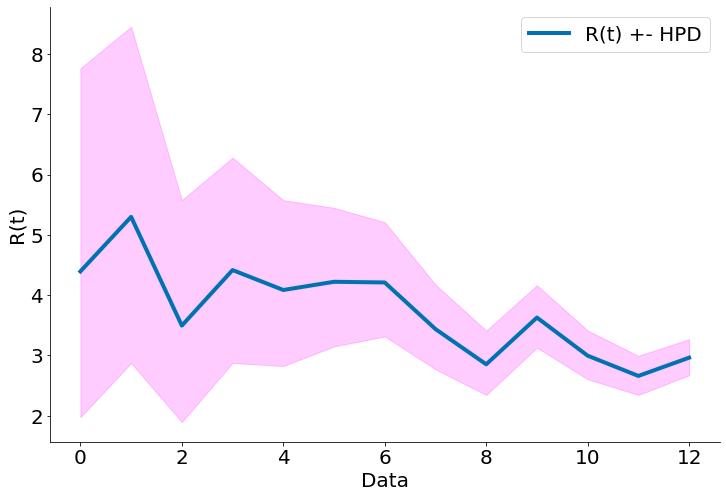

In [8]:
df_orig = pd.read_excel('./data/COVID-19-geographic-disbtribution-worldwide-2020-03-28.xlsx')
df_br = df_orig[df_orig['countriesAndTerritories'] == 'Brazil']
who_df = df_br[['cases']].copy()
who_df.columns = ['local']
who_df.index = pd.to_datetime(df_br['dateRep'])
who_df = who_df.sort_index().fillna(0)
first_day = np.nonzero(who_df.values)[0][0]
who_df = who_df[first_day:]
who_df = who_df[:'2020-03-19']

with localconverter(ro.default_converter + pandas2ri.converter):
    epiestim_result = epiestim.estimate_R(who_df,
                                          method='parametric_si',
                                          config=config)
    epiestim_result = pandas2ri.ri2py(epiestim_result[0])

plot_result(epiestim_result)

In [9]:
datasets = {}
sheets = glob.glob('data/covid19/[A-Z]*/*.xlsx')
for sheet in sorted(sheets):
    state = os.path.basename(sheet)[:2]
    region = os.path.basename(os.path.dirname(sheet))
    if region not in datasets:
        datasets[region] = {}
    datasets[region][state] = sheet

In [10]:
for region in datasets:
    for state, fpath in datasets[region].items():
        try:
            df = load_data(fpath)
            with localconverter(ro.default_converter + pandas2ri.converter):
                model_df = df[['TOTAL NO ESTADO', 'Importados/Indefinidos']].copy()
                model_df.columns = ['local', 'imported']
                epiestim_result = epiestim.estimate_R(model_df,
                                                      method='parametric_si',
                                                      config=config)
                epiestim_result = pandas2ri.ri2py(epiestim_result[0])
            plt.title(state)
            plot_result(epiestim_result, model_df)
            try:
                os.makedirs('plots/{}/'.format(region))
            except:
                pass
            plt.tight_layout()
            plt.savefig('plots/{}/{}.png'.format(region, state))
            plt.close()
        except:
            pass

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch